In [1]:
import numpy as np
import scipy
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from func_util import *
from func_SE3_generators import *
from scipy.optimize import least_squares, minimize
from io import BytesIO
from PIL import Image

In [ ]:
P1 = np.zeros((3,4), dtype=float)
P1[0:3,0:3] = np.identity(3)

R1 = np.array([[-0.999984,    0.0018146,  -0.00527047],[ -0.00181666,    -0.999998,  0.000386248],[  0.00526976, -0.000395817,    -0.999986]])
R2 = np.array([[0.970467, 0.0585565, -0.234021],[0.0595465,  0.881927,   0.46761],[-0.233771,  0.467735, -0.852394]])
tvec = np.array([-0.124274,  0.24305, -0.96202])
Kmat = np.array([[1141.29,       0, 984.083],[0, 1141.65, 604.018],[0,       0,      1]])
pt1 = np.array([1389.24,57.1354,      1])
pt2 = np.array([1396.18,57.2726,       1])

fc = np.array([Kmat[0,0], Kmat[1,1]])
cc = np.array([Kmat[0,2], Kmat[1,2]])
wh = np.array([1920, 1200]) 

# 4 solutions from essential matrix decomposition
P2_l = []
for i in xrange(4):
    P2_l.append(np.zeros((3,4), dtype=float))

P2_l[0][0:3,0:3] = R1
P2_l[0][0:3,3] = tvec

P2_l[1][0:3,0:3] = R1
P2_l[1][0:3,3] = -tvec

P2_l[2][0:3,0:3] = R2
P2_l[2][0:3,3] = tvec

P2_l[3][0:3,0:3] = R2
P2_l[3][0:3,3] = -tvec

pt1norm = np.dot(np.linalg.inv(Kmat), pt1)
pt2norm = np.dot(np.linalg.inv(Kmat), pt2)

In [ ]:
def func_get_crossm(t): 
    ret = np.zeros((3,3), dtype=float) 
    ret[1,0] = t[2] 
    ret[2,0] = -t[1] 
    ret[2,1] = t[0] 
    ret[0,1] = -ret[1,0] 
    ret[0,2] = -ret[2,0] 
    ret[1,2] = -ret[2,1]
    return ret

def func_invert_transform(Pin): 
    P = Pin.copy() 
    P[0:3,0:3] = P[0:3,0:3].T # R.T 
    P[0:3,3] = np.dot(-P[0:3,0:3], P[0:3,3]) # -R.T * t 
    return P
    
def func_P_to_Rt(P): 
    return P[0:3,0:3], P[0:3,3]

In [ ]:

for i in xrange(4):
    P2 = P2_l[i]; # Select solution to display
    # Verify essential matrix
    R,t = func_P_to_Rt(P2)
    essm = np.dot(R, func_get_crossm(t))
    fmat = np.dot(np.dot(Kmat.transpose(), essm), Kmat)
    eline = np.dot(fmat, pt1)
    eline /= np.linalg.norm(eline[0:2])
    print np.dot(eline, pt2) # has to match the C++ point transfer error
    
    # Prepare point bearing directions
    pt1trafo = np.dot(P1[0:3,0:3].transpose(), pt1norm) # rotate from canonical into camera
    pt2trafo = np.dot(P2[0:3,0:3].transpose(), pt2norm)
    
    print np.linalg.norm(np.dot(P2[0:3,0:3].transpose(), P2[2,0:3])-np.array([0,0,1]))
    print np.linalg.norm(np.dot(P2[0:3,0:3], P2[2,0:3])-np.array([0,0,1])) # rotate from cam to canonical
    
    pt1trafo /= np.linalg.norm(pt1trafo)
    pt2trafo /= np.linalg.norm(pt2trafo)
    
    print "pt1 ", pt1trafo
    print "pt2 ", pt2trafo
    
    # LSQ solution for intersection and depth from both cameras
    A = np.vstack((pt1trafo, -pt2trafo)).T
    b = P2[0:3,3]-P1[0:3,3]
    res = np.linalg.lstsq(A,b)
    print A, b
    print "Depth", res[0]
    print "Residuals", res[1]
    ptit1 = P1[0:3,3] + res[0][0]*pt1trafo
    ptit2 = P2[0:3,3] + res[0][1]*pt2trafo

    print ptit1
    print ptit2
    print "ErrN", np.linalg.norm(ptit1 - ptit2)
    
    
    # Calculare direction rays for display
    pt1plta = P1[0:3,3] + 2*pt1trafo;
    pt2plta = P2[0:3,3] + 2*pt2trafo;
    pt1pltb = P1[0:3,3] - 2*pt1trafo;
    pt2pltb = P2[0:3,3] - 2*pt2trafo;

    # Display cameras in robot frame
    fig = plt.figure(figsize=(16, 12))
    ax = fig.add_subplot(111, projection='3d')

    ccdisp = cc - wh/2
    camcol = np.array([1.0, 0.0, 0.0])
    R,t = func_P_to_Rt(P1)
    func_plot_cameras(ax, fc, ccdisp, wh, R, t, rgbface=camcol, camerascaling=.5)
    ax.scatter(P1[0,3], P1[1,3], P1[2,3], color=np.array([0.0, 0.0, 0.0]), linewidth=5)
    ax.plot(np.array([pt1plta[0], pt1pltb[0]]),np.array([pt1plta[1], pt1pltb[1]]),np.array([pt1plta[2], pt1pltb[2]]), color=np.array([0.0, 0.0, 0.0]), linewidth=0.5)    
    
    camcol = np.array([0.0, 0.0, 1.0])
    R,t = func_P_to_Rt(P2)
    func_plot_cameras(ax, fc, ccdisp, wh, R, t, rgbface=camcol, camerascaling=.5)
    ax.scatter(P2[0,3], P2[1,3], P2[2,3], color=np.array([0.0, 0.0, 0.0]), linewidth=5)
    ax.plot(np.array([pt2plta[0], pt2pltb[0]]),np.array([pt2plta[1], pt2pltb[1]]),np.array([pt2plta[2], pt2pltb[2]]), color=np.array([0.0, 0.0, 0.0]), linewidth=0.5)

    ax.scatter(ptit1[0], ptit1[1], ptit1[2], color=np.array([0.0, 1.0, 0.0]), linewidth=5)
    
    func_set_axes_equal(ax)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    plt.show()

    
# Pick solution with both depth >0    

In [ ]:
# Plot t -> t+1 change from text file
fstart = 2300
fend = 2600
for i in xrange(fstart, fend):
    for camno in xrange(12):
        filename = '/tmp/pose_cam{:02}_{:06}.txt'.format(camno, i)
        lines = [float(line.rstrip('\n')) for line in open(filename)] 
        if (len(lines)>0):
            nn = np.array(lines);

            Rot_c = np.array(nn[0:9]).reshape(3,3)
            tvec_c =  np.array(nn[9:12])
            Rot_b = np.array(nn[12:21]).reshape(3,3)
            tvec_b =  np.array(nn[21::])
            tvec_b = tvec_b / np.linalg.norm(tvec_b)

            # Display cameras in robot frame
            fig = plt.figure(figsize=(12, 8))
            ax = fig.add_subplot(111, projection='3d')

            ccdisp = cc - wh/2
            camcol = np.array([1.0, 0.0, 0.0])
            func_plot_cameras(ax, fc, ccdisp, wh, np.identity(3), np.array([0,0,0]), rgbface=camcol, camerascaling=.5, lw=4.0)

            camcol = np.array([0.0, 1.0, 0.0])
            func_plot_cameras(ax, fc, ccdisp, wh, Rot_c, tvec_c, rgbface=camcol, camerascaling=.5, lw=4.0)
            camcol = np.array([0.0, 0.0, 1.0])
            func_plot_cameras(ax, fc, ccdisp, wh, Rot_b, tvec_b, rgbface=camcol, camerascaling=.5, lw=4.0)

            ax.set_xlim(-.75, .75)
            ax.set_ylim(-.75, .75)
            ax.set_zlim(-.75, .75)
            func_set_axes_equal(ax)

            ax.set_xlabel('x')
            ax.set_ylabel('y')
            ax.set_zlabel('z')
            plt.show()
            savefile =  filename + "_.png"
            fig.savefig(savefile, format='png')            
            plt.clf();


In [ ]:
import cv2
# Load camera solutions, and combine images
camstr_all = ['north_wide_left', 'north_wide_right','north_narrow_left','north_narrow_right','east_wide_right','east_wide_left' ,'south_wide_left','south_wide_right','west_wide_left','west_wide_right','south_narrow_left','south_narrow_right']
fstart = 2300
fend = 2600
for i in xrange(fstart, fend):
    if (i%50==0) :
        print i    
    for camno in xrange(12):    
        
        camstr = camstr_all[camno]
        
        img = cv2.imread('/home/till/Results/out_' + camstr +'_{:06}.png'.format(i))
        
        filename = '/tmp/pose_cam{:02}_{:06}.txt'.format(camno, i)
        lines = [float(line.rstrip('\n')) for line in open(filename)] 
        if (len(lines)>0):
            imga = cv2.imread(filename + "_.png")
            perccut = 0.1
            imga = imga[int(imga.shape[0]*perccut):int(imga.shape[0] - imga.shape[0]*perccut),int(imga.shape[1]*perccut):int(imga.shape[1] - imga.shape[1]*perccut),:]
            w = img.shape[1]/4
            h = img.shape[0]/4
            img[-h:, 0:w,:] = cv2.resize(imga, (w, h))

        cv2.imwrite('/tmp/essent_test_cam{:02}_{:06}.png'.format(camno, i), img)
        
    imgs = []
    for camno in xrange(12):
        imgs.append(cv2.imread('/tmp/essent_test_cam{:02}_{:06}.png'.format(camno, i)))
    imgres_a = np.concatenate((imgs[0], imgs[1], imgs[2], imgs[3]), axis=1)
    imgres_b = np.concatenate((imgs[4], imgs[5], imgs[6], imgs[7]), axis=1)
    imgres_c = np.concatenate((imgs[8], imgs[9], imgs[10], imgs[11]), axis=1)
    imgres = np.concatenate((imgres_a, imgres_b, imgres_c), axis=0)
    imgres = cv2.resize(imgres, (imgs[0].shape[1]*2, imgs[0].shape[0]*2))

    cv2.imwrite('/tmp/essent_test_all_{:06}.png'.format(i), imgres)        

In [ ]:
# Compare orignal poses, clams'ed poses, batch mofo poses

lines_l = []
for camno in xrange(12):    
    #lines = [float(line.rstrip('\n')) for line in open('/tmp/fperr_org/fperr_cam{:02}.txt'.format(camno))] 
    lines = [float(line.rstrip('\n')) for line in open('/tmp/fperr_cam{:02}.txt'.format(camno))] 
    lines_l.append(np.array(lines))
err_org = np.vstack(lines_l).T

lines_l = []
for camno in xrange(12):    
    lines = [float(line.rstrip('\n')) for line in open('/tmp/fperr_clams/fperr_cam{:02}.txt'.format(camno))] 
    lines_l.append(np.array(lines))
err_clams = np.vstack(lines_l).T
print err_clams.shape

lines_l = []
for camno in xrange(12):    
    lines = [float(line.rstrip('\n')) for line in open('/tmp/fperr_bMOFO/fperr_cam{:02}.txt'.format(camno))] 
    lines_l.append(np.array(lines))
err_bMOFO = np.vstack(lines_l).T

max_sc = np.max([np.nanmax(err_org), np.nanmax(err_clams), np.nanmax(err_bMOFO)])

# Plot, LINEAR
f, axarr = plt.subplots(3, 4, figsize=(16, 12), sharex=True, sharey=True)
for camno in xrange(12):
    
    axarr[camno/4, camno%4].plot(xrange(err_org.shape[0]), err_org[:,camno], label='wMOFO')
    #axarr[camno/4, camno%4].plot(xrange(err_clams.shape[0]), err_clams[:,camno], label='clams')
    #axarr[camno/4, camno%4].plot(xrange(err_bMOFO.shape[0]), err_bMOFO[:,camno], label='bMOFO')
    axarr[camno/4, camno%4].set_title(camstr_all[camno])
    #axarr[camno/4, camno%4].set_yscale("log")
    
    #axarr[camno/4, camno%4].xrange([0, max_sc])
# Fine-tune figure; hide x ticks for top plots and y ticks for right plots
plt.setp([a.get_xticklabels() for a in axarr[0, :]], visible=False)
plt.setp([a.get_xticklabels() for a in axarr[1, :]], visible=False)
plt.setp([a.get_yticklabels() for a in axarr[:, 1]], visible=False)
plt.setp([a.get_yticklabels() for a in axarr[:, 2]], visible=False)
plt.setp([a.get_yticklabels() for a in axarr[:, 3]], visible=False)

axarr[0,0].legend(loc="upper left", bbox_to_anchor=[0, 1])
for i in xrange(3):
    axarr[i,0].set_ylabel('RMS px err')
for i in xrange(4):    
    axarr[2,i].set_xlabel('t')
plt.show()




In [ ]:
# Compare add noise

lines_l = []
for camno in xrange(12):    
    lines = [float(line.rstrip('\n')) for line in open('/tmp/fperr_cam{:02}.txt'.format(camno))] 
    lines_l.append(np.array(lines))
err_org = np.vstack(lines_l).T

max_sc = np.max([np.nanmax(err_org), np.nanmax(err_clams), np.nanmax(err_bMOFO)])

# load simulated noise
fstart = 2300
fend = 2315
lines_l = []
for i in xrange(fstart, fend):
    for camno in xrange(12):    
        lines = [float(line.rstrip('\n')) for line in open('/tmp/fperr_org/fperr_simul_cam{:02}_{:06}.txt'.format(camno, i))] 
        lines_l.append(np.array(lines))



# Plot, LINEAR
f, axarr = plt.subplots(3, 4, figsize=(16, 12), sharex=True, sharey=True)
for camno in xrange(12):
    
    axarr[camno/4, camno%4].plot(xrange(err_org.shape[0]), err_org[:,camno], label='base')
    axarr[camno/4, camno%4].set_title(camstr_all[camno])
    #axarr[camno/4, camno%4].set_yscale("log")
    
    #axarr[camno/4, camno%4].xrange([0, max_sc])
# Fine-tune figure; hide x ticks for top plots and y ticks for right plots
plt.setp([a.get_xticklabels() for a in axarr[0, :]], visible=False)
plt.setp([a.get_xticklabels() for a in axarr[1, :]], visible=False)
plt.setp([a.get_yticklabels() for a in axarr[:, 1]], visible=False)
plt.setp([a.get_yticklabels() for a in axarr[:, 2]], visible=False)
plt.setp([a.get_yticklabels() for a in axarr[:, 3]], visible=False)

axarr[0,0].legend(loc="upper left", bbox_to_anchor=[0, 1])
for i in xrange(3):
    axarr[i,0].set_ylabel('RMS px err')
for i in xrange(4):    
    axarr[2,i].set_xlabel('t')
plt.show()



In [ ]:
# load simulated noise
fstart = 2300
fend = 2550
arange = [0.0, 0.1, 0.5, 1.0] # degrees
trange = [0.0, 0.1, 0.5, 1.0] # meters

perr_org = np.zeros((fend-fstart, 12), dtype=float)
perr_base = np.zeros((fend-fstart, 12), dtype=float)
perr_sim_t = np.zeros((fend-fstart, len(trange), 12), dtype=float)
perr_sim_r = np.zeros((fend-fstart, len(arange), 12), dtype=float)

max_sc = 1

for camno in xrange(12):
    lines_l = []
    for i in xrange(fstart, fend):
        lines = [float(line.rstrip('\n')) for line in open('/tmp/fperr_simul_cam{:02}_{:06}.txt'.format(camno, i))] 
        lines = np.array(lines)
        perr_org[i-fstart, camno] = lines[0]
        #perr_base[i-fstart, camno] = lines[1]
        perr_sim_r[i-fstart,0, camno] = lines[1]
        perr_sim_t[i-fstart,0, camno] = lines[1]
        perr_sim_r[i-fstart,1::, camno] = lines[2:5]
        perr_sim_t[i-fstart,1::, camno] = lines[5::]
    
    
# Plot, LINEAR
f, axarr = plt.subplots(3, 4, figsize=(16, 12), sharex=True, sharey=True)
for camno in xrange(12):
    axarr[camno/4, camno%4].plot(xrange(fstart, fend), perr_org[:, camno], label='model fit. err.')
    axarr[camno/4, camno%4].hold('on')
    #axarr[camno/4, camno%4].plot(xrange(fstart, fend), perr_base[:, camno], label='org. cal. err. ')
    for i in xrange(perr_sim_t.shape[1]):
        axarr[camno/4, camno%4].plot(xrange(fstart, fend), perr_sim_t[:,i, camno], label='t_err {} m'.format(trange[i]))
    axarr[camno/4, camno%4].set_title(camstr_all[camno])    
    axarr[camno/4, camno%4].set_ylim([0, max_sc])
# Fine-tune figure; hide x ticks for top plots and y ticks for right plots
plt.setp([a.get_xticklabels() for a in axarr[0, :]], visible=False)
plt.setp([a.get_xticklabels() for a in axarr[1, :]], visible=False)
plt.setp([a.get_yticklabels() for a in axarr[:, 1]], visible=False)
plt.setp([a.get_yticklabels() for a in axarr[:, 2]], visible=False)
plt.setp([a.get_yticklabels() for a in axarr[:, 3]], visible=False)

axarr[0,0].legend(loc="upper left", bbox_to_anchor=[0, 1])
for i in xrange(3):
    axarr[i,0].set_ylabel('RMS px err')
for i in xrange(4):    
    axarr[2,i].set_xlabel('t')
plt.show()



# Plot, LINEAR
f, axarr = plt.subplots(3, 4, figsize=(16, 12), sharex=True, sharey=True)
for camno in xrange(12):
    axarr[camno/4, camno%4].plot(xrange(fstart, fend), perr_org[:, camno], label='model fit. err.')
    #axarr[camno/4, camno%4].plot(xrange(fstart, fend), perr_base[:, camno], label='org. cal. err.')        
    for i in xrange(perr_sim_t.shape[1]):
        axarr[camno/4, camno%4].plot(xrange(fstart, fend), perr_sim_r[:,i, camno], label='t_err {} deg'.format(trange[i]))
    axarr[camno/4, camno%4].set_title(camstr_all[camno])
    axarr[camno/4, camno%4].set_ylim([0, max_sc])
# Fine-tune figure; hide x ticks for top plots and y ticks for right plots
plt.setp([a.get_xticklabels() for a in axarr[0, :]], visible=False)
plt.setp([a.get_xticklabels() for a in axarr[1, :]], visible=False)
plt.setp([a.get_yticklabels() for a in axarr[:, 1]], visible=False)
plt.setp([a.get_yticklabels() for a in axarr[:, 2]], visible=False)
plt.setp([a.get_yticklabels() for a in axarr[:, 3]], visible=False)

axarr[0,0].legend(loc="upper left", bbox_to_anchor=[0, 1])
for i in xrange(3):
    axarr[i,0].set_ylabel('RMS px err')
for i in xrange(4):    
    axarr[2,i].set_xlabel('t')
plt.show()


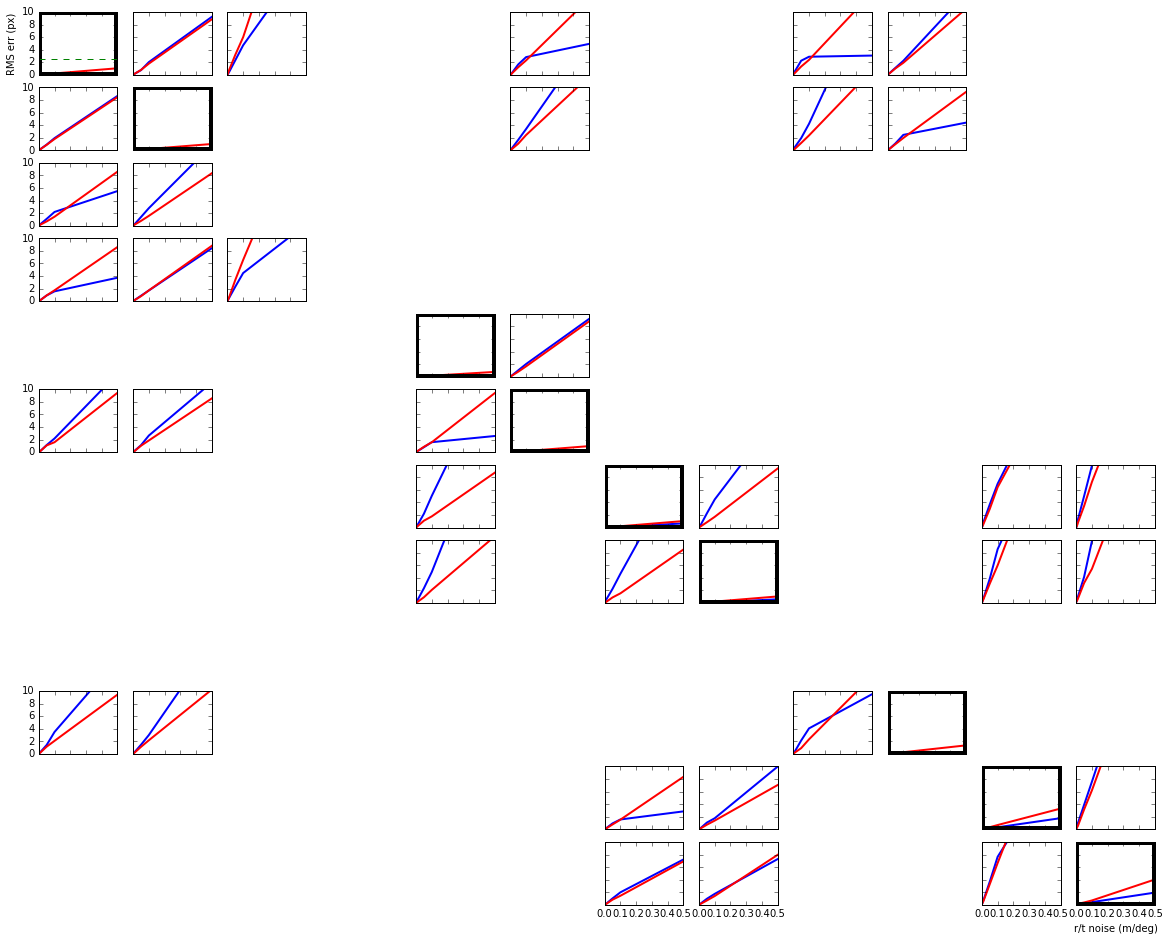

In [77]:
trange_res = []
arange_res = []
ylimval = 10
for camno in xrange(12):    
    trange_res.append([])
    arange_res.append([])
    for camno_next in xrange(12):    
        line = [line.rstrip('\n') for line in open('/tmp/rms_err_cam{:02}_cam{:02}.txt'.format(camno,camno_next))] 
        line = np.fromstring(line[0], dtype=float, sep=' ')
        ttmp = line[0:line.shape[0]/2]
        trange = ttmp[::2].copy()
        trange_res[-1].append(ttmp[1::2].copy())
        ttmp = line[line.shape[0]/2:]
        arange = ttmp[::2].copy()
        arange_res[-1].append(ttmp[1::2].copy())
        
# Plot, LINEAR
f, axarr = plt.subplots(12, 12, figsize=(20, 16), sharex=True, sharey=True)
for camno in xrange(12):
    for camno_next in xrange(12):
        if (not np.isnan(trange_res[camno][camno_next][0])):
            axarr[camno, camno_next].plot(trange, trange_res[camno][camno_next], color='b', linewidth=2)
            axarr[camno, camno_next].hold('on')
            axarr[camno, camno_next].plot(arange, arange_res[camno][camno_next], color='r', linewidth=2)            
            axarr[camno, camno_next].set_ylim([0, ylimval])
            if (camno==camno_next):
                axarr[camno, camno_next].axhline(linewidth=6, color='k')
                axarr[camno, camno_next].axhline(linewidth=6, color='k', y=ylimval)                
                axarr[camno, camno_next].axvline(linewidth=6, color='k')
                axarr[camno, camno_next].axvline(linewidth=6, color='k', x=trange[-1])
                if (camno==0):
                    axarr[camno, camno_next].axhline(linewidth=1, color='g', linestyle='--', y=2.5)
        else: 
            axarr[camno, camno_next].axis('off')

#axarr[0,0].legend(loc="upper left", bbox_to_anchor=[0, 1])
#for i in xrange(12):
axarr[0,0].set_ylabel('RMS err (px)')
#for i in xrange(4):    
axarr[11,11].set_xlabel('r/t noise (m/deg)')
plt.show()